In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os

import torch.optim as optim
import torch.nn.functional as F
import math
import torchvision.models as models



from torchvision import datasets, transforms, models
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from torch.utils.checkpoint import checkpoint

from collections import defaultdict


In [2]:
os.getcwd()

'/home/rapids/notebooks/data/storage/slima'

In [3]:
os.chdir("/home/rapids/notebooks/data/storage/slima/lfw")

In [4]:
## hyperparameters

#LFW subdirectory of images
lfw_dataset='lfw'
lfw_dataset_path = lfw_dataset
min_images_per_class = 1  # for example, classes with at least 5 images
#lfw_dataset_path = 'lfw'
pairs_file = 'lfw_test_pair_short.txt'

# Number of epochs to train for
num_epochs = 100
#num_classes = 10 # No of images to upload in the dataset

#normalization size in pixels
resizex=112
resizey= 112

embedding_size=512
train_ratio=0.99

#Arcface and Fuzzy Arcface m, tau  and s
margin=0.5
scale_s=64
tauparameter=0.9

#SDG optimizer related for Arcface and FuzzyArcface
learning_rate= 0.1
momentum= 0.9
weight_decay= 5e-4
    

In [5]:
import random
random.seed(42)  # Set the seed to a fixed number


In [6]:
import torch
torch.manual_seed(42)  # Set the seed for PyTorch


In [7]:
print(torch.__version__)  #1.11.0+cpu
print(torch.cuda.is_available())


2.1.2+cu121
True


In [8]:
if torch.cuda.device_count() > 1:
    print(f"{torch.cuda.device_count()} GPUs available")
else:
    print("Single GPU or no GPU available")


4 GPUs available


In [9]:

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


In [10]:

# If using CUDA (PyTorch)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # if you are using multi-GPU.



In [11]:
# Enforce deterministic behavior in PyTorch (optional, may impact performance)
# This is important for reproducibility, especially for certain operations on GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((resizex, resizey)),  # Resize to the input size of the pre-trained model
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ImageNet
])


In [13]:

# # Assuming the dataset is in 'lfw_dataset' directory
# dataset = ImageFolder(root=lfw_dataset, transform=transform)
# # The number of classes
# n_classes = len(dataset.classes)

# print(f"The LFW dataset has {n_classes} classes.")

In [14]:

class CustomImageFolder(ImageFolder):
    def __init__(self, root, min_imgs_per_class, transform=None):
        self.min_imgs_per_class = min_imgs_per_class
        super().__init__(root, transform=transform)

    def find_classes(self, directory):
        classes = []
        dir_to_class = {}
        for target in sorted(os.listdir(directory)):
            d = os.path.join(directory, target)
            if not os.path.isdir(d):
                continue
            if len(os.listdir(d)) >= self.min_imgs_per_class:
                classes.append(target)
                dir_to_class[target] = len(classes) - 1
        return classes, dir_to_class

# Define the path to your dataset and the minimum number of images per class



In [15]:


# Create the dataset
dataset = CustomImageFolder(root=lfw_dataset_path, min_imgs_per_class=min_images_per_class, transform=transform)

# Number of classes
n_classes = len(dataset.classes)
print(f"The LFW dataset has {n_classes} classes after filtering.")


The LFW dataset has 5749 classes after filtering.


In [16]:

#Trained with 100% of LFW database according to filter
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])



In [17]:
# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [18]:
# Ensure your model is loaded and has been trained already, and that the dataloaders are available

# This function will extract embeddings from the model
def get_embeddings(dataloader, model):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []
    #model.fc = nn.Linear(model.fc.in_features, 512)  # for a 512-dimensional embedding feature extraction

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # This assumes the model has already been modified to output embeddings directly
            embeddings.extend(outputs.data.cpu().numpy())
            labels.extend(targets.numpy())

    return np.array(embeddings), np.array(labels)


In [19]:
def plot_embeddings_3d(embeddings, labels, title):
    """
    Perform t-SNE on embeddings and plot the results.
    """
    # Perform t-SNE embedding
    tsne = TSNE(n_components=3, random_state=123)
    embeddings_tsne = tsne.fit_transform(embeddings)

    # Plot the result of the t-SNE embedding
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot of the embeddings, color-coded by label
    scatter = ax.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], embeddings_tsne[:, 2], c=labels, cmap='tab10')

    # Add color bar which maps values to colors
    cbar = plt.colorbar(scatter, ax=ax)
    plt.show()

In [20]:
def plot_embeddings_2d(embeddings, labels, title):
    """
    Perform t-SNE on embeddings and plot the results.
    """
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.grid(True)
    plt.show()

ARCFACE

In [21]:
#iRESNET100 IMPLEMENTATION


__all__ = ['iresnet18', 'iresnet34', 'iresnet50', 'iresnet100', 'iresnet200']
using_ckpt = False

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class IBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1):
        super(IBasicBlock, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.bn1 = nn.BatchNorm2d(inplanes, eps=1e-05,)
        self.conv1 = conv3x3(inplanes, planes)
        self.bn2 = nn.BatchNorm2d(planes, eps=1e-05,)
        self.prelu = nn.PReLU(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn3 = nn.BatchNorm2d(planes, eps=1e-05,)
        self.downsample = downsample
        self.stride = stride

    def forward_impl(self, x):
        identity = x
        out = self.bn1(x)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return out        

    def forward(self, x):
        if self.training and using_ckpt:
            return checkpoint(self.forward_impl, x)
        else:
            return self.forward_impl(x)


class IResNet(nn.Module):
    fc_scale = 7 * 7  * 4  #for dim 224x 224
    fc_scale = 7 * 7    #for dim 112x 112
    
    def __init__(self,
                 block, layers, dropout=0, embedding_size=embedding_size, num_features=n_classes, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None, fp16=False):
        super(IResNet, self).__init__()
        self.extra_gflops = 0.0
        self.fp16 = fp16
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes, eps=1e-05)
        self.prelu = nn.PReLU(self.inplanes)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block,
                                       128,
                                       layers[1],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block,
                                       256,
                                       layers[2],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block,
                                       512,
                                       layers[3],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.bn2 = nn.BatchNorm2d(512 * block.expansion, eps=1e-05,)
        self.dropout = nn.Dropout(p=dropout, inplace=True)
        self.fc = nn.Linear(512 * block.expansion * self.fc_scale, embedding_size)
        self.features = nn.BatchNorm1d(embedding_size, eps=1e-05)
        nn.init.constant_(self.features.weight, 1.0)
        self.features.weight.requires_grad = False

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.1)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, IBasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion, eps=1e-05, ),
            )
        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, self.groups,
                  self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes,
                      planes,
                      groups=self.groups,
                      base_width=self.base_width,
                      dilation=self.dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        with torch.cuda.amp.autocast(self.fp16):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.prelu(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.bn2(x)
            x = torch.flatten(x, 1)
            x = self.dropout(x)
        x = self.fc(x.float() if self.fp16 else x)
        x = self.features(x)
        return x


def _iresnet(arch, block, layers, pretrained, progress, **kwargs):
    model = IResNet(block, layers, **kwargs)
    if pretrained:
        raise ValueError()
    return model


def iresnet18(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet18', IBasicBlock, [2, 2, 2, 2], pretrained,
                    progress, **kwargs)


def iresnet34(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet34', IBasicBlock, [3, 4, 6, 3], pretrained,
                    progress, **kwargs)


def iresnet50(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet50', IBasicBlock, [3, 4, 14, 3], pretrained,
                    progress, **kwargs)


def iresnet100(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet100', IBasicBlock, [3, 13, 30, 3], pretrained,
                    progress, **kwargs)


def iresnet200(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet200', IBasicBlock, [6, 26, 60, 6], pretrained,
                    progress, **kwargs)

In [22]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=scale_s, m=margin, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = torch.cos(torch.tensor(m))  # Convert m to a tensor
        self.sin_m = torch.sin(torch.tensor(m))  # Convert m to a tensor
        self.th = torch.cos(torch.tensor(math.pi) - torch.tensor(m))  # Convert math.pi and m to tensors
        self.mm = torch.sin(torch.tensor(math.pi) - torch.tensor(m)) * m


    def forward(self, input, label):
        # normalize features
        #self.weight = self.weight.to(input.device)  # Move weight to the device of input
            # Ensure self.weight is on the same device as input
            
        #print(f"Input device: {input.device}")
        #print(f"Weight device: {self.weight.device}")
    
        if self.weight.device != input.device:
            self.weight = self.weight.to(input.device)
            print("equalized")
        
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [24]:
# Example, assuming you're using a ResNet model
model = iresnet100()
# in_features = model.fc.in_features  # Get the number of input features from the model
# out_features = n_classes  # The number of classes in your dataset

# # Replace the last layer of your model with a linear layer for embedding extraction
# model.fc = nn.Linear(in_features, out_features)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

model.to(device) 
#embedding_size = n_classes  # Your chosen embedding size

# Move the model to the appropriate device
#model = model.to(device)


DataParallel(
  (module): IResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
    (layer1): Sequential(
      (0): IBasicBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=64)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [25]:

# Initialize the ArcMarginProduct layer
#arcface_layer = ArcMarginProduct(n_classes, embedding_size).to(device)

arcface_layer = ArcMarginProduct(in_features=embedding_size, out_features=n_classes).to(device)


In [26]:
# Define the loss function and optimizer
#criterion = nn.CrossEntropyLoss()
# Define the loss and optimizer
criterion = FocalLoss(gamma=2)
#optimizer = optim.Adam(list(model.parameters()) + list(arcface_layer.parameters()), lr=0.001)
optimizer = optim.SGD(
            params=[{"params": model.parameters()}, {"params":arcface_layer.parameters()}],
            lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

In [27]:

j=0
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        j+=1
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass through the model to get the embeddings
        embeddings = model(inputs)

        # Forward pass through the ArcMarginProduct layer
        logits = arcface_layer(embeddings, labels)

        # Compute the loss
        loss = criterion(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Print statistics
        running_loss += loss.item()
        #print("loss, j", loss, j)

        if j % 100 == 99:    # print every 100 mini-batches
            print(f'Epoch: {epoch + 1}, Batch: {j + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training Arcface')


Epoch: 1, Batch: 100, Loss: 62.155178756713866
Epoch: 1, Batch: 200, Loss: 60.75555603027344
Epoch: 1, Batch: 300, Loss: 57.55865657806397
Epoch: 1, Batch: 400, Loss: 55.685563621521
Epoch: 2, Batch: 500, Loss: 39.97609889984131
Epoch: 2, Batch: 600, Loss: 40.461681900024416
Epoch: 2, Batch: 700, Loss: 40.11344520568848
Epoch: 2, Batch: 800, Loss: 40.00150512695313
Epoch: 3, Batch: 900, Loss: 31.129648361206055
Epoch: 3, Batch: 1000, Loss: 39.51449775695801
Epoch: 3, Batch: 1100, Loss: 39.55669746398926
Epoch: 3, Batch: 1200, Loss: 39.55139785766602
Epoch: 4, Batch: 1300, Loss: 26.63364719390869
Epoch: 4, Batch: 1400, Loss: 38.96038112640381
Epoch: 4, Batch: 1500, Loss: 39.15327167510986
Epoch: 4, Batch: 1600, Loss: 39.373501205444335
Epoch: 5, Batch: 1700, Loss: 22.01795509338379
Epoch: 5, Batch: 1800, Loss: 38.198861045837404
Epoch: 5, Batch: 1900, Loss: 38.895163764953615
Epoch: 5, Batch: 2000, Loss: 39.43661510467529
Epoch: 6, Batch: 2100, Loss: 17.26172451019287
Epoch: 6, Batch: 2

In [28]:

# Save the model state dict
torch.save(model.state_dict(), 'arcface_resnet101_customized4.pth')

In [29]:

# Load the model state dict
model.load_state_dict(torch.load('arcface_resnet101_customized4.pth'))
# Move the model to the appropriate device (CPU or GPU)
model = model.to(device)

In [30]:

# Assuming test_loader is defined and loads the LFW dataset
embeddings_arcface, labels_arcface = get_embeddings(test_loader, model)



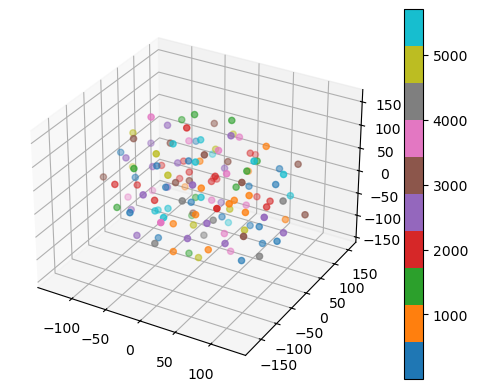

In [31]:

# Plot for the model trained with ArcFace
plot_embeddings_3d(embeddings_arcface, labels_arcface, 't-SNE of 3D ArcFace Model Embeddings')


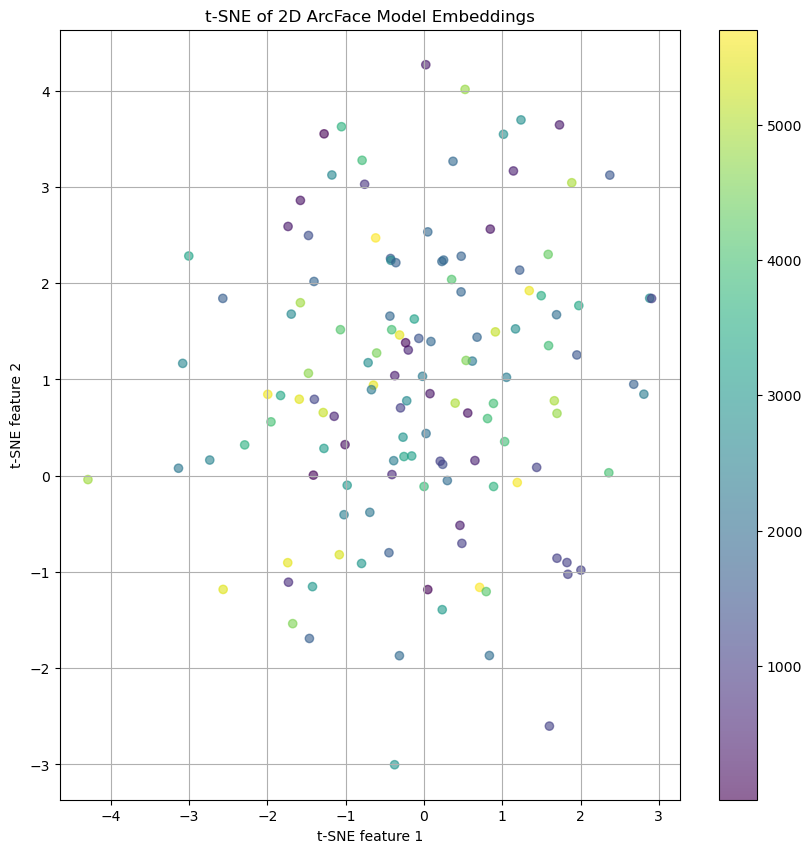

In [32]:

# Plot for the model trained with ArcFace
plot_embeddings_2d(embeddings_arcface, labels_arcface, 't-SNE of 2D ArcFace Model Embeddings')


FUZZY ARCFACE

In [33]:
class FuzzyArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=scale_s, m=margin, tau=tauparameter, easy_margin=False):
        super(FuzzyArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.tau = tau
        self.easy_margin = easy_margin
 

    def forward(self, input, label):
        # normalize features
        if self.weight.device != input.device:
            self.weight = self.weight.to(input.device)
            print("equalized")
        
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        
        #fuzzy membership based on cosine, values could be -1 to 1
        fuzzy_membership=cosine
        # Keep values greater than 0 and greater than tau, and less than or equal to 1
        mask = torch.logical_and(torch.logical_and(fuzzy_membership > 0, fuzzy_membership >= self.tau), fuzzy_membership <= 1)
        # Apply mask
        fuzzy_membership = torch.where(mask, fuzzy_membership, torch.ones_like(fuzzy_membership))
        #adjust m
        m_adjusted = self.m * fuzzy_membership
        
        
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        
        # Compute phi with adjusted m
        cos_m_adjusted = torch.cos(m_adjusted)
        sin_m_adjusted = torch.sin(m_adjusted)
        phi = cosine * cos_m_adjusted - sine * sin_m_adjusted
   
       
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > torch.cos(torch.tensor(math.pi) - m_adjusted), phi, cosine - torch.sin(torch.tensor(math.pi) - m_adjusted) * m_adjusted)

            
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        return output

In [34]:
# Example, assuming you're using a ResNet model
model = iresnet100()
# in_features = model.fc.in_features  # Get the number of input features from the model
# out_features = n_classes  # The number of classes in your dataset

# # Replace the last layer of your model with a linear layer for embedding extraction
# model.fc = nn.Linear(in_features, out_features)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

model.to(device) 
#embedding_size = n_classes  # Your chosen embedding size



DataParallel(
  (module): IResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
    (layer1): Sequential(
      (0): IBasicBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=64)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [35]:
# Initialize the ArcMarginProduct layer
fuzzyarcface_layer = FuzzyArcFace(in_features=embedding_size, out_features=n_classes).to(device)

# Move the model to the appropriate device
#model = model.to(device)

In [36]:
# Define the loss function and optimizer
#criterion = nn.CrossEntropyLoss()
# Define the loss and optimizer
criterion = FocalLoss(gamma=2)
#optimizer = optim.Adam(list(model.parameters()) + list(arcface_layer.parameters()), lr=0.001)
optimizer = optim.SGD(
            params=[{"params": model.parameters()}, {"params":fuzzyarcface_layer.parameters()}],
            lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

In [37]:

j=0
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        j+=1
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass through the model to get the embeddings
        embeddings = model(inputs)

        # Forward pass through the ArcMarginProduct layer
        logits = fuzzyarcface_layer(embeddings, labels)

        # Compute the loss
        loss = criterion(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Print statistics
        running_loss += loss.item()
        #print("loss, j", loss, j)

        if j % 100 == 99:    # print every 100 mini-batches
            print(f'Epoch: {epoch + 1}, Batch: {j + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training FuzzyArcface')

Epoch: 1, Batch: 100, Loss: 61.134080238342285
Epoch: 1, Batch: 200, Loss: 58.54097896575928
Epoch: 1, Batch: 300, Loss: 55.99825622558594
Epoch: 1, Batch: 400, Loss: 54.660053749084476
Epoch: 2, Batch: 500, Loss: 39.0211559677124
Epoch: 2, Batch: 600, Loss: 40.06177749633789
Epoch: 2, Batch: 700, Loss: 39.68694129943847
Epoch: 2, Batch: 800, Loss: 39.659844131469725
Epoch: 3, Batch: 900, Loss: 30.421156692504884
Epoch: 3, Batch: 1000, Loss: 38.758144798278806
Epoch: 3, Batch: 1100, Loss: 38.93332286834717
Epoch: 3, Batch: 1200, Loss: 39.24521282196045
Epoch: 4, Batch: 1300, Loss: 25.589848899841307
Epoch: 4, Batch: 1400, Loss: 37.83843662261963
Epoch: 4, Batch: 1500, Loss: 38.33589950561523
Epoch: 4, Batch: 1600, Loss: 38.82896770477295
Epoch: 5, Batch: 1700, Loss: 20.63556022644043
Epoch: 5, Batch: 1800, Loss: 35.828280448913574
Epoch: 5, Batch: 1900, Loss: 36.60873245239258
Epoch: 5, Batch: 2000, Loss: 37.2338888168335
Epoch: 6, Batch: 2100, Loss: 15.339086494445802
Epoch: 6, Batch:

In [38]:

# Save the model state dict
torch.save(model.state_dict(), 'fuzzyarcface_resnet101_customized4.pth')

In [39]:

# Load the model state dict
model.load_state_dict(torch.load('fuzzyarcface_resnet101_customized4.pth'))
# Move the model to the appropriate device (CPU or GPU)
model = model.to(device)

In [40]:

# Assuming test_loader is defined and loads the LFW dataset
embeddings_farcface, labels_farcface = get_embeddings(test_loader, model)


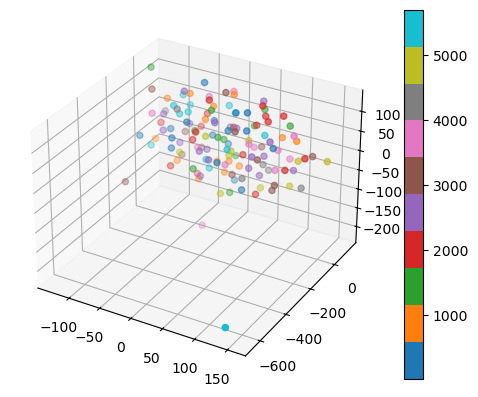

In [41]:

# Plot for the model trained with ArcFace
plot_embeddings_3d(embeddings_farcface, labels_farcface, 't-SNE of 3D Fuzzy ArcFace Model Embeddings')


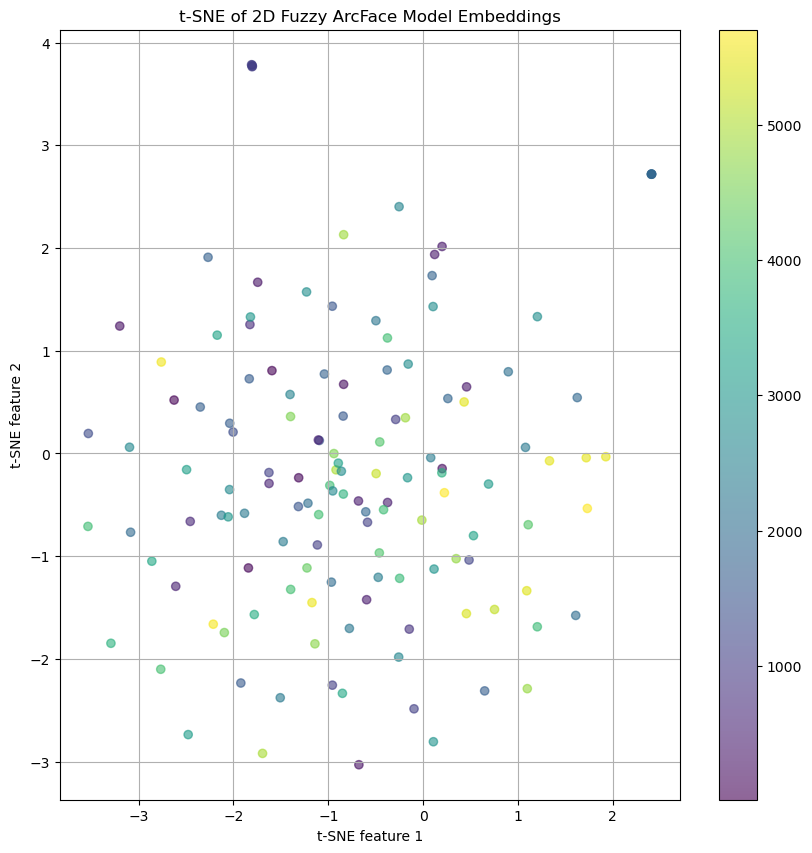

In [42]:

# Plot for the model trained with ArcFace
plot_embeddings_2d(embeddings_farcface, labels_farcface, 't-SNE of 2D Fuzzy ArcFace Model Embeddings')


TESTING

In [43]:
def evaluate_accuracy(dataloader, model, device):
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)


    model.to(device)
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    i=0
    with torch.no_grad():
        for data, target in dataloader:
            # data contains the image, target contains the label
            img1, img2 = data  # Assuming each batch has a pair of images
            img1, img2 = img1.to(device), img2.to(device)
            target = target.to(device)

            emb1, emb2 = model(img1), model(img2)
            emb1, emb2 = emb1.view(emb1.size(0), -1), emb2.view(emb2.size(0), -1)
            #print("embed pair", emb1, emb2, i)
            print("embed shape",emb1.shape,emb2.shape, i)
            
            cosine_similarity = torch.nn.functional.cosine_similarity(emb1, emb2)
            print("embed cosine similarity",cosine_similarity, i)
            prediction = (cosine_similarity > 0.5).int()
            i+=1
            correct_predictions += (prediction == target).item()
            total_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

In [44]:

#architecture for ARCFACE AND FUZZYARCFACE

# Base architecture, e.g., ResNet50
def create_base_model():
    model = iresnet100()
    #model.fc = nn.Linear(model.fc.in_features, n_classes)  # Adjust for embedding size
    #num_ftrs = model.fc.in_features
    #model.fc = torch.nn.Linear(num_ftrs, 512)  # Modify the last FC layer for 512-dimension embedding
   # model.fc = nn.Linear(num_ftrs, n_classes)
    #model.fc = nn.Linear(model.fc.in_features, n_classes)  # Replace the last layer
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    return model


In [45]:

# Define models for each training method
arcface_model = create_base_model()
#softmax_model = create_base_model2()
fuzzyarcface_model = create_base_model()

In [46]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image


class LFWDataset(Dataset):
    def __init__(self, root_dir, pairs_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.pairs = []
        self.labels = []
        self.prepare_pairs(pairs_file)

    def prepare_pairs(self, pairs_file):
        with open(pairs_file, 'r') as file:
            lines = file.readlines()
            for line in lines:
                parts = line.strip().split()
                img1_path = os.path.join(self.root_dir, parts[0])
                img2_path = os.path.join(self.root_dir, parts[1])
                label = int(parts[2])

                self.pairs.append((img1_path, img2_path))
                self.labels.append(label)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path = self.pairs[idx]
        label = self.labels[idx]

        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (img1, img2), label

In [47]:
# Define the paths



# Initialize the dataset
lfw_dataset = LFWDataset(root_dir=lfw_dataset_path, pairs_file=pairs_file, transform=transform)

# Create a DataLoader
test_loader = DataLoader(lfw_dataset, batch_size=1, shuffle=False)


In [48]:

# Load each model and set to evaluation mode
arcface_model.load_state_dict(torch.load('arcface_resnet101_customized4.pth'))
#softmax_model.load_state_dict(torch.load('softmax_resnet101_customized3.pth'))
fuzzyarcface_model.load_state_dict(torch.load('fuzzyarcface_resnet101_customized4.pth'))


<All keys matched successfully>

In [49]:

# Evaluate each model
arcface_accuracy = evaluate_accuracy(test_loader, arcface_model, device)
print(f'ArcFace LFW Accuracy: {arcface_accuracy}')
#softmax_accuracy = evaluate_accuracy(test_loader, softmax_model, device)
#print(f'Softmax LFW Accuracy: {softmax_accuracy}')
fuzzyarcface_accuracy = evaluate_accuracy(test_loader, fuzzyarcface_model, device)
print(f'FuzzyArcface LFW Accuracy: {fuzzyarcface_accuracy}')

embed shape torch.Size([1, 512]) torch.Size([1, 512]) 0
embed cosine similarity tensor([0.6720], device='cuda:0') 0
embed shape torch.Size([1, 512]) torch.Size([1, 512]) 1
embed cosine similarity tensor([0.6827], device='cuda:0') 1
embed shape torch.Size([1, 512]) torch.Size([1, 512]) 2
embed cosine similarity tensor([0.6802], device='cuda:0') 2
embed shape torch.Size([1, 512]) torch.Size([1, 512]) 3
embed cosine similarity tensor([0.7107], device='cuda:0') 3
embed shape torch.Size([1, 512]) torch.Size([1, 512]) 4
embed cosine similarity tensor([0.7084], device='cuda:0') 4
embed shape torch.Size([1, 512]) torch.Size([1, 512]) 5
embed cosine similarity tensor([0.6624], device='cuda:0') 5
embed shape torch.Size([1, 512]) torch.Size([1, 512]) 6
embed cosine similarity tensor([0.5364], device='cuda:0') 6
embed shape torch.Size([1, 512]) torch.Size([1, 512]) 7
embed cosine similarity tensor([0.5998], device='cuda:0') 7
embed shape torch.Size([1, 512]) torch.Size([1, 512]) 8
embed cosine sim

1. Triplet Loss
Triplet loss is commonly used in tasks where the goal is to learn an embedding space. In this space, distances between embeddings of the same class (positive pairs) are minimized, and distances between embeddings of different classes (negative pairs) are maximized. This is particularly popular in face recognition and person re-identification tasks.

Usage: You need a triplet of samples: an anchor, a positive example (same class as the anchor), and a negative example (different class from the anchor). The loss is calculated based on the relative distances between these three points in the embedding space.
2. Contrastive Loss
Contrastive loss is used for learning embeddings by contrasting positive pairs against negative pairs. It encourages positive pairs to be closer in the embedding space and negative pairs to be farther apart.

Usage: Requires pairs of samples. Each pair is labeled as similar or dissimilar. The loss function minimizes the distance between similar pairs while ensuring that the distance between dissimilar pairs is above a certain margin.
3. Cosine Similarity Loss
This loss function can be used when the angle between embeddings is more important than the Euclidean distance. It is useful in many applications where the magnitude of the embedding vectors is not as important as their direction.

Usage: Often used in combination with other losses, cosine similarity measures the cosine of the angle between two vectors. It can be used to ensure that embeddings from the same class are aligned in direction, regardless of their magnitude.
4. ArcFace Loss
As you mentioned ArcFace, it's worth noting again here. ArcFace provides a geometrically interpretable additive angular margin for softmax loss, which enhances the discriminative power of the embeddings. It's specifically designed for face recognition and works by ensuring that the embeddings of the same class are closer together while embeddings from different classes are farther apart by an angular margin.

Usage: Directly applicable to tasks aiming for discriminative embeddings, such as face recognition. Requires embedding output and class labels to compute the loss.
5. SphereFace and CosFace
Similar to ArcFace, SphereFace and CosFace are also designed to enhance the discriminative power of the embeddings for face recognition and other similar tasks. They modify the softmax loss to include angular margins.

Choosing a Loss Function
The choice among these loss functions depends on your specific task requirements:

For generic embedding learning where the relationship between pairs or triplets is important, Triplet Loss or Contrastive Loss might be suitable.
For tasks where you aim to maximize the discriminative power of embeddings, especially in face recognition, ArcFace, SphereFace, or CosFace might be more appropriate.